In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Layer
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
from keras.constraints import Constraint
import pickle

In [2]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 401.8727
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.9537
t_final = 0.005
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

num_step = 10

In [3]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
T_initial = np.linspace(300, 600, 100, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 100, endpoint=True) - C_As

In [4]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 772
shape of x_deviation is (772, 2)


In [5]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
          C_A_list.append(C_A - C_As)  # in deviation form
          T_list.append(T - T_s)  # in deviation form

    return C_A_list, T_list

In [6]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s

    for u2 in u2_list:
        Q = u2 + Q_s

        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)

            C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [7]:
CA0_input = np.array(CA0_input)
print(CA0_input.shape)
CA_output = np.array(CA_output)
print(CA_output.shape)

(12352,)
(12352, 10)


In [8]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

CA0_input_neg = -np.array(CA0_input)
CA0_input_neg = CA0_input_neg.reshape(-1,1,1)

Q_input_neg = -np.array(Q_input)
Q_input_neg = Q_input_neg.reshape(-1,1,1)

CA_input_neg = -np.array(CA_input)
CA_input_neg = CA_input_neg.reshape(-1,1,1)

T_input_neg = -np.array(T_input)
T_input_neg = T_input_neg.reshape(-1,1,1)

RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""

RNN_input = RNN_input.repeat(num_step, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (12352, 10, 4)


In [9]:
# checking the input is duplicated 100 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]
[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]


In [10]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, num_step, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, num_step, 1)

RNN_output = np.concatenate((T_output, CA_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (12352, 10, 2)


In [11]:
# checking output
print(RNN_output[0, :5])

[[-74.82498608   1.43869052]
 [-75.94937347   1.43097798]
 [-77.07255531   1.4233169 ]
 [-78.19443649   1.41570516]
 [-79.31492759   1.4081408 ]]


In [46]:
# set the seed for reproducibility
tf.random.set_seed(42)

training_loss = [0]*10
test_loss = [0]*10
noise = 0
for i in range(10):
  num_dims = 4

  # split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

  # # define scalers for both X and y base on training data only
  scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, num_dims))
  scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))

  X_train = scaler_X.transform(X_train.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
  X_test = scaler_X.transform(X_test.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
  y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,num_step,2)
  y_test_normalized = scaler_y.transform(y_test.reshape(-1,2)).reshape(-1,num_step,2)

  y_train = y_train + np.random.normal(0, noise, y_train.shape)

  model = Sequential()
  model.add(SimpleRNN(512, activation='relu', return_sequences=True))
  model.add(SimpleRNN(512, activation='relu', return_sequences=True))
  model.add(Dense(2, activation='linear'))

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
  history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_split=0.25, verbose=2)
  training_loss[i] = history.history['val_loss'][-1]
  print(training_loss)

  loss = model.evaluate(X_test, y_test_normalized, batch_size=256)
  test_loss[i] = loss[0]
  print(test_loss)

  name = 'rnn_512_'
  name = name + str(noise) + '.h5'
  model.save(name)

  noise = noise + 0.1

model.summary()

Epoch 1/200
26/26 - 4s - loss: 0.1035 - mean_squared_error: 0.1035 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - 4s/epoch - 170ms/step
Epoch 2/200
26/26 - 3s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - 3s/epoch - 109ms/step
Epoch 3/200
26/26 - 3s - loss: 7.7487e-04 - mean_squared_error: 7.7487e-04 - val_loss: 4.8324e-04 - val_mean_squared_error: 4.8324e-04 - 3s/epoch - 111ms/step
Epoch 4/200
26/26 - 3s - loss: 3.3621e-04 - mean_squared_error: 3.3621e-04 - val_loss: 2.5237e-04 - val_mean_squared_error: 2.5237e-04 - 3s/epoch - 110ms/step
Epoch 5/200
26/26 - 3s - loss: 2.0516e-04 - mean_squared_error: 2.0516e-04 - val_loss: 1.8153e-04 - val_mean_squared_error: 1.8153e-04 - 3s/epoch - 110ms/step
Epoch 6/200
26/26 - 3s - loss: 1.5418e-04 - mean_squared_error: 1.5418e-04 - val_loss: 1.4065e-04 - val_mean_squared_error: 1.4065e-04 - 3s/epoch - 107ms/step
Epoch 7/200
26/26 - 3s - loss: 1.2578e-04 - mean_squared_error: 1.2578e-04 - v

Epoch 53/200
26/26 - 3s - loss: 2.1589e-05 - mean_squared_error: 2.1589e-05 - val_loss: 1.8726e-05 - val_mean_squared_error: 1.8726e-05 - 3s/epoch - 108ms/step
Epoch 54/200
26/26 - 3s - loss: 1.7293e-05 - mean_squared_error: 1.7293e-05 - val_loss: 2.3129e-05 - val_mean_squared_error: 2.3129e-05 - 3s/epoch - 107ms/step
Epoch 55/200
26/26 - 3s - loss: 2.3119e-05 - mean_squared_error: 2.3119e-05 - val_loss: 2.2876e-05 - val_mean_squared_error: 2.2876e-05 - 3s/epoch - 108ms/step
Epoch 56/200
26/26 - 3s - loss: 3.0372e-05 - mean_squared_error: 3.0372e-05 - val_loss: 6.1621e-05 - val_mean_squared_error: 6.1621e-05 - 3s/epoch - 107ms/step
Epoch 57/200
26/26 - 3s - loss: 5.8701e-05 - mean_squared_error: 5.8701e-05 - val_loss: 3.2410e-05 - val_mean_squared_error: 3.2410e-05 - 3s/epoch - 109ms/step
Epoch 58/200
26/26 - 3s - loss: 6.3874e-05 - mean_squared_error: 6.3874e-05 - val_loss: 1.5700e-04 - val_mean_squared_error: 1.5700e-04 - 3s/epoch - 105ms/step
Epoch 59/200
26/26 - 3s - loss: 2.6742e-

Epoch 105/200
26/26 - 4s - loss: 7.4934e-04 - mean_squared_error: 7.4934e-04 - val_loss: 1.7595e-04 - val_mean_squared_error: 1.7595e-04 - 4s/epoch - 146ms/step
Epoch 106/200
26/26 - 4s - loss: 1.0114e-04 - mean_squared_error: 1.0114e-04 - val_loss: 6.7289e-05 - val_mean_squared_error: 6.7289e-05 - 4s/epoch - 141ms/step
Epoch 107/200
26/26 - 4s - loss: 3.8830e-05 - mean_squared_error: 3.8830e-05 - val_loss: 3.8061e-05 - val_mean_squared_error: 3.8061e-05 - 4s/epoch - 143ms/step
Epoch 108/200
26/26 - 4s - loss: 2.4979e-05 - mean_squared_error: 2.4979e-05 - val_loss: 2.5438e-05 - val_mean_squared_error: 2.5438e-05 - 4s/epoch - 140ms/step
Epoch 109/200
26/26 - 4s - loss: 1.8086e-05 - mean_squared_error: 1.8086e-05 - val_loss: 2.0352e-05 - val_mean_squared_error: 2.0352e-05 - 4s/epoch - 138ms/step
Epoch 110/200
26/26 - 4s - loss: 1.6196e-05 - mean_squared_error: 1.6196e-05 - val_loss: 1.6740e-05 - val_mean_squared_error: 1.6740e-05 - 4s/epoch - 139ms/step
Epoch 111/200
26/26 - 4s - loss: 1

Epoch 156/200
26/26 - 4s - loss: 4.0548e-04 - mean_squared_error: 4.0548e-04 - val_loss: 1.4675e-04 - val_mean_squared_error: 1.4675e-04 - 4s/epoch - 142ms/step
Epoch 157/200
26/26 - 4s - loss: 3.3729e-04 - mean_squared_error: 3.3729e-04 - val_loss: 7.8742e-04 - val_mean_squared_error: 7.8742e-04 - 4s/epoch - 142ms/step
Epoch 158/200
26/26 - 4s - loss: 2.7932e-04 - mean_squared_error: 2.7932e-04 - val_loss: 1.9770e-04 - val_mean_squared_error: 1.9770e-04 - 4s/epoch - 141ms/step
Epoch 159/200
26/26 - 4s - loss: 6.4858e-05 - mean_squared_error: 6.4858e-05 - val_loss: 2.9677e-05 - val_mean_squared_error: 2.9677e-05 - 4s/epoch - 143ms/step
Epoch 160/200
26/26 - 4s - loss: 2.0003e-05 - mean_squared_error: 2.0003e-05 - val_loss: 1.3427e-05 - val_mean_squared_error: 1.3427e-05 - 4s/epoch - 144ms/step
Epoch 161/200
26/26 - 4s - loss: 1.5158e-05 - mean_squared_error: 1.5158e-05 - val_loss: 1.0715e-05 - val_mean_squared_error: 1.0715e-05 - 4s/epoch - 144ms/step
Epoch 162/200
26/26 - 4s - loss: 9

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 8s - loss: 0.1327 - mean_squared_error: 0.1327 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - 8s/epoch - 320ms/step
Epoch 2/200
26/26 - 4s - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - 4s/epoch - 138ms/step
Epoch 3/200
26/26 - 4s - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - 4s/epoch - 138ms/step
Epoch 4/200
26/26 - 4s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 4s/epoch - 136ms/step
Epoch 5/200
26/26 - 4s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 4s/epoch - 139ms/step
Epoch 6/200
26/26 - 4s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 4s/epoch - 135ms/step
Epoch 7/200
26/26 - 3s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 3s/epoch - 134ms/step

Epoch 58/200
26/26 - 4s - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - 4s/epoch - 141ms/step
Epoch 59/200
26/26 - 4s - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 4s/epoch - 140ms/step
Epoch 60/200
26/26 - 4s - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - 4s/epoch - 141ms/step
Epoch 61/200
26/26 - 4s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - 4s/epoch - 140ms/step
Epoch 62/200
26/26 - 4s - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 4s/epoch - 140ms/step
Epoch 63/200
26/26 - 4s - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - 4s/epoch - 141ms/step
Epoch 64/200
26/26 - 4s - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - 4s/epoch - 142

Epoch 115/200
26/26 - 4s - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - 4s/epoch - 140ms/step
Epoch 116/200
26/26 - 4s - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - 4s/epoch - 140ms/step
Epoch 117/200
26/26 - 4s - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - 4s/epoch - 139ms/step
Epoch 118/200
26/26 - 4s - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - 4s/epoch - 139ms/step
Epoch 119/200
26/26 - 4s - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - 4s/epoch - 139ms/step
Epoch 120/200
26/26 - 4s - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - 4s/epoch - 139ms/step
Epoch 121/200
26/26 - 4s - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - 4s/epoc

Epoch 172/200
26/26 - 4s - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - 4s/epoch - 139ms/step
Epoch 173/200
26/26 - 4s - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - 4s/epoch - 138ms/step
Epoch 174/200
26/26 - 4s - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - 4s/epoch - 139ms/step
Epoch 175/200
26/26 - 4s - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - 4s/epoch - 141ms/step
Epoch 176/200
26/26 - 4s - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - 4s/epoch - 138ms/step
Epoch 177/200
26/26 - 4s - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - 4s/epoch - 140ms/step
Epoch 178/200
26/26 - 4s - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - 4s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 8s - loss: 0.1318 - mean_squared_error: 0.1318 - val_loss: 0.0480 - val_mean_squared_error: 0.0480 - 8s/epoch - 291ms/step
Epoch 2/200
26/26 - 4s - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - 4s/epoch - 140ms/step
Epoch 3/200
26/26 - 4s - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 4s/epoch - 138ms/step
Epoch 4/200
26/26 - 4s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 4s/epoch - 137ms/step
Epoch 5/200
26/26 - 4s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 4s/epoch - 140ms/step
Epoch 6/200
26/26 - 4s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 4s/epoch - 141ms/step
Epoch 7/200
26/26 - 4s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - 4s/epoch - 141ms/step

Epoch 58/200
26/26 - 4s - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - 4s/epoch - 141ms/step
Epoch 59/200
26/26 - 4s - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - 4s/epoch - 139ms/step
Epoch 60/200
26/26 - 4s - loss: 0.0396 - mean_squared_error: 0.0396 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - 4s/epoch - 141ms/step
Epoch 61/200
26/26 - 4s - loss: 0.0396 - mean_squared_error: 0.0396 - val_loss: 0.0419 - val_mean_squared_error: 0.0419 - 4s/epoch - 141ms/step
Epoch 62/200
26/26 - 4s - loss: 0.0395 - mean_squared_error: 0.0395 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - 4s/epoch - 139ms/step
Epoch 63/200
26/26 - 4s - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - 4s/epoch - 140ms/step
Epoch 64/200
26/26 - 4s - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - 4s/epoch - 140

Epoch 115/200
26/26 - 4s - loss: 0.0380 - mean_squared_error: 0.0380 - val_loss: 0.0425 - val_mean_squared_error: 0.0425 - 4s/epoch - 138ms/step
Epoch 116/200
26/26 - 4s - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0423 - val_mean_squared_error: 0.0423 - 4s/epoch - 139ms/step
Epoch 117/200
26/26 - 4s - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - 4s/epoch - 139ms/step
Epoch 118/200
26/26 - 4s - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0426 - val_mean_squared_error: 0.0426 - 4s/epoch - 140ms/step
Epoch 119/200
26/26 - 4s - loss: 0.0377 - mean_squared_error: 0.0377 - val_loss: 0.0425 - val_mean_squared_error: 0.0425 - 4s/epoch - 140ms/step
Epoch 120/200
26/26 - 4s - loss: 0.0375 - mean_squared_error: 0.0375 - val_loss: 0.0423 - val_mean_squared_error: 0.0423 - 4s/epoch - 140ms/step
Epoch 121/200
26/26 - 4s - loss: 0.0375 - mean_squared_error: 0.0375 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - 4s/epoc

Epoch 172/200
26/26 - 4s - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 4s/epoch - 136ms/step
Epoch 173/200
26/26 - 4s - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 4s/epoch - 136ms/step
Epoch 174/200
26/26 - 4s - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 4s/epoch - 136ms/step
Epoch 175/200
26/26 - 4s - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 4s/epoch - 136ms/step
Epoch 176/200
26/26 - 4s - loss: 0.0352 - mean_squared_error: 0.0352 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 4s/epoch - 137ms/step
Epoch 177/200
26/26 - 4s - loss: 0.0351 - mean_squared_error: 0.0351 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - 4s/epoch - 138ms/step
Epoch 178/200
26/26 - 4s - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - 4s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 11s - loss: 0.1932 - mean_squared_error: 0.1932 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 11s/epoch - 441ms/step
Epoch 2/200
26/26 - 6s - loss: 0.0935 - mean_squared_error: 0.0935 - val_loss: 0.0913 - val_mean_squared_error: 0.0913 - 6s/epoch - 212ms/step
Epoch 3/200
26/26 - 6s - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0914 - val_mean_squared_error: 0.0914 - 6s/epoch - 212ms/step
Epoch 4/200
26/26 - 5s - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - 5s/epoch - 208ms/step
Epoch 5/200
26/26 - 6s - loss: 0.0912 - mean_squared_error: 0.0912 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 6s/epoch - 213ms/step
Epoch 6/200
26/26 - 6s - loss: 0.0905 - mean_squared_error: 0.0905 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 6s/epoch - 213ms/step
Epoch 7/200
26/26 - 6s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 6s/epoch - 216ms/st

Epoch 58/200
26/26 - 6s - loss: 0.0875 - mean_squared_error: 0.0875 - val_loss: 0.0931 - val_mean_squared_error: 0.0931 - 6s/epoch - 222ms/step
Epoch 59/200
26/26 - 6s - loss: 0.0878 - mean_squared_error: 0.0878 - val_loss: 0.0926 - val_mean_squared_error: 0.0926 - 6s/epoch - 221ms/step
Epoch 60/200
26/26 - 6s - loss: 0.0876 - mean_squared_error: 0.0876 - val_loss: 0.0926 - val_mean_squared_error: 0.0926 - 6s/epoch - 225ms/step
Epoch 61/200
26/26 - 6s - loss: 0.0871 - mean_squared_error: 0.0871 - val_loss: 0.0925 - val_mean_squared_error: 0.0925 - 6s/epoch - 222ms/step
Epoch 62/200
26/26 - 6s - loss: 0.0873 - mean_squared_error: 0.0873 - val_loss: 0.0933 - val_mean_squared_error: 0.0933 - 6s/epoch - 225ms/step
Epoch 63/200
26/26 - 6s - loss: 0.0876 - mean_squared_error: 0.0876 - val_loss: 0.0929 - val_mean_squared_error: 0.0929 - 6s/epoch - 224ms/step
Epoch 64/200
26/26 - 6s - loss: 0.0873 - mean_squared_error: 0.0873 - val_loss: 0.0932 - val_mean_squared_error: 0.0932 - 6s/epoch - 225

Epoch 115/200
26/26 - 6s - loss: 0.0829 - mean_squared_error: 0.0829 - val_loss: 0.0974 - val_mean_squared_error: 0.0974 - 6s/epoch - 222ms/step
Epoch 116/200
26/26 - 6s - loss: 0.0831 - mean_squared_error: 0.0831 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 6s/epoch - 225ms/step
Epoch 117/200
26/26 - 6s - loss: 0.0831 - mean_squared_error: 0.0831 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 6s/epoch - 221ms/step
Epoch 118/200
26/26 - 6s - loss: 0.0829 - mean_squared_error: 0.0829 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - 6s/epoch - 220ms/step
Epoch 119/200
26/26 - 6s - loss: 0.0825 - mean_squared_error: 0.0825 - val_loss: 0.0977 - val_mean_squared_error: 0.0977 - 6s/epoch - 223ms/step
Epoch 120/200
26/26 - 6s - loss: 0.0829 - mean_squared_error: 0.0829 - val_loss: 0.0993 - val_mean_squared_error: 0.0993 - 6s/epoch - 225ms/step
Epoch 121/200
26/26 - 6s - loss: 0.0828 - mean_squared_error: 0.0828 - val_loss: 0.0974 - val_mean_squared_error: 0.0974 - 6s/epoc

Epoch 172/200
26/26 - 6s - loss: 0.0758 - mean_squared_error: 0.0758 - val_loss: 0.1064 - val_mean_squared_error: 0.1064 - 6s/epoch - 238ms/step
Epoch 173/200
26/26 - 6s - loss: 0.0757 - mean_squared_error: 0.0757 - val_loss: 0.1038 - val_mean_squared_error: 0.1038 - 6s/epoch - 239ms/step
Epoch 174/200
26/26 - 6s - loss: 0.0755 - mean_squared_error: 0.0755 - val_loss: 0.1054 - val_mean_squared_error: 0.1054 - 6s/epoch - 235ms/step
Epoch 175/200
26/26 - 7s - loss: 0.0753 - mean_squared_error: 0.0753 - val_loss: 0.1052 - val_mean_squared_error: 0.1052 - 7s/epoch - 272ms/step
Epoch 176/200
26/26 - 7s - loss: 0.0749 - mean_squared_error: 0.0749 - val_loss: 0.1054 - val_mean_squared_error: 0.1054 - 7s/epoch - 279ms/step
Epoch 177/200
26/26 - 7s - loss: 0.0748 - mean_squared_error: 0.0748 - val_loss: 0.1060 - val_mean_squared_error: 0.1060 - 7s/epoch - 277ms/step
Epoch 178/200
26/26 - 7s - loss: 0.0747 - mean_squared_error: 0.0747 - val_loss: 0.1057 - val_mean_squared_error: 0.1057 - 7s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 254s - loss: 0.2498 - mean_squared_error: 0.2498 - val_loss: 0.1678 - val_mean_squared_error: 0.1678 - 254s/epoch - 10s/step
Epoch 2/200
26/26 - 11s - loss: 0.1646 - mean_squared_error: 0.1646 - val_loss: 0.1626 - val_mean_squared_error: 0.1626 - 11s/epoch - 435ms/step
Epoch 3/200
26/26 - 11s - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1619 - val_mean_squared_error: 0.1619 - 11s/epoch - 415ms/step
Epoch 4/200
26/26 - 11s - loss: 0.1623 - mean_squared_error: 0.1623 - val_loss: 0.1621 - val_mean_squared_error: 0.1621 - 11s/epoch - 411ms/step
Epoch 5/200
26/26 - 11s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1617 - val_mean_squared_error: 0.1617 - 11s/epoch - 415ms/step
Epoch 6/200
26/26 - 11s - loss: 0.1622 - mean_squared_error: 0.1622 - val_loss: 0.1624 - val_mean_squared_error: 0.1624 - 11s/epoch - 435ms/step
Epoch 7/200
26/26 - 12s - loss: 0.1622 - mean_squared_error: 0.1622 - val_loss: 0.1617 - val_mean_squared_error: 0.1617 - 12s/epoc

Epoch 58/200
26/26 - 9s - loss: 0.1565 - mean_squared_error: 0.1565 - val_loss: 0.1668 - val_mean_squared_error: 0.1668 - 9s/epoch - 334ms/step
Epoch 59/200
26/26 - 9s - loss: 0.1566 - mean_squared_error: 0.1566 - val_loss: 0.1662 - val_mean_squared_error: 0.1662 - 9s/epoch - 341ms/step
Epoch 60/200
26/26 - 9s - loss: 0.1569 - mean_squared_error: 0.1569 - val_loss: 0.1660 - val_mean_squared_error: 0.1660 - 9s/epoch - 345ms/step
Epoch 61/200
26/26 - 9s - loss: 0.1565 - mean_squared_error: 0.1565 - val_loss: 0.1667 - val_mean_squared_error: 0.1667 - 9s/epoch - 340ms/step
Epoch 62/200
26/26 - 9s - loss: 0.1563 - mean_squared_error: 0.1563 - val_loss: 0.1666 - val_mean_squared_error: 0.1666 - 9s/epoch - 343ms/step
Epoch 63/200
26/26 - 9s - loss: 0.1566 - mean_squared_error: 0.1566 - val_loss: 0.1681 - val_mean_squared_error: 0.1681 - 9s/epoch - 336ms/step
Epoch 64/200
26/26 - 9s - loss: 0.1562 - mean_squared_error: 0.1562 - val_loss: 0.1664 - val_mean_squared_error: 0.1664 - 9s/epoch - 341

Epoch 115/200
26/26 - 10s - loss: 0.1470 - mean_squared_error: 0.1470 - val_loss: 0.1759 - val_mean_squared_error: 0.1759 - 10s/epoch - 374ms/step
Epoch 116/200
26/26 - 10s - loss: 0.1461 - mean_squared_error: 0.1461 - val_loss: 0.1765 - val_mean_squared_error: 0.1765 - 10s/epoch - 382ms/step
Epoch 117/200
26/26 - 10s - loss: 0.1458 - mean_squared_error: 0.1458 - val_loss: 0.1774 - val_mean_squared_error: 0.1774 - 10s/epoch - 367ms/step
Epoch 118/200
26/26 - 10s - loss: 0.1455 - mean_squared_error: 0.1455 - val_loss: 0.1750 - val_mean_squared_error: 0.1750 - 10s/epoch - 377ms/step
Epoch 119/200
26/26 - 10s - loss: 0.1456 - mean_squared_error: 0.1456 - val_loss: 0.1779 - val_mean_squared_error: 0.1779 - 10s/epoch - 386ms/step
Epoch 120/200
26/26 - 10s - loss: 0.1451 - mean_squared_error: 0.1451 - val_loss: 0.1776 - val_mean_squared_error: 0.1776 - 10s/epoch - 377ms/step
Epoch 121/200
26/26 - 9s - loss: 0.1452 - mean_squared_error: 0.1452 - val_loss: 0.1770 - val_mean_squared_error: 0.17

Epoch 172/200
26/26 - 9s - loss: 0.1315 - mean_squared_error: 0.1315 - val_loss: 0.1936 - val_mean_squared_error: 0.1936 - 9s/epoch - 343ms/step
Epoch 173/200
26/26 - 9s - loss: 0.1313 - mean_squared_error: 0.1313 - val_loss: 0.1934 - val_mean_squared_error: 0.1934 - 9s/epoch - 333ms/step
Epoch 174/200
26/26 - 9s - loss: 0.1301 - mean_squared_error: 0.1301 - val_loss: 0.1946 - val_mean_squared_error: 0.1946 - 9s/epoch - 339ms/step
Epoch 175/200
26/26 - 9s - loss: 0.1293 - mean_squared_error: 0.1293 - val_loss: 0.1957 - val_mean_squared_error: 0.1957 - 9s/epoch - 341ms/step
Epoch 176/200
26/26 - 9s - loss: 0.1290 - mean_squared_error: 0.1290 - val_loss: 0.1945 - val_mean_squared_error: 0.1945 - 9s/epoch - 337ms/step
Epoch 177/200
26/26 - 9s - loss: 0.1298 - mean_squared_error: 0.1298 - val_loss: 0.1931 - val_mean_squared_error: 0.1931 - 9s/epoch - 347ms/step
Epoch 178/200
26/26 - 9s - loss: 0.1291 - mean_squared_error: 0.1291 - val_loss: 0.1934 - val_mean_squared_error: 0.1934 - 9s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 292s - loss: 0.3386 - mean_squared_error: 0.3386 - val_loss: 0.2592 - val_mean_squared_error: 0.2592 - 292s/epoch - 11s/step
Epoch 2/200
26/26 - 11s - loss: 0.2523 - mean_squared_error: 0.2523 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 11s/epoch - 418ms/step
Epoch 3/200
26/26 - 11s - loss: 0.2498 - mean_squared_error: 0.2498 - val_loss: 0.2541 - val_mean_squared_error: 0.2541 - 11s/epoch - 406ms/step
Epoch 4/200
26/26 - 11s - loss: 0.2494 - mean_squared_error: 0.2494 - val_loss: 0.2540 - val_mean_squared_error: 0.2540 - 11s/epoch - 413ms/step
Epoch 5/200
26/26 - 11s - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.2532 - val_mean_squared_error: 0.2532 - 11s/epoch - 413ms/step
Epoch 6/200
26/26 - 11s - loss: 0.2481 - mean_squared_error: 0.2481 - val_loss: 0.2531 - val_mean_squared_error: 0.2531 - 11s/epoch - 435ms/step
Epoch 7/200
26/26 - 11s - loss: 0.2478 - mean_squared_error: 0.2478 - val_loss: 0.2534 - val_mean_squared_error: 0.2534 - 11s/epoc

Epoch 58/200
26/26 - 9s - loss: 0.2401 - mean_squared_error: 0.2401 - val_loss: 0.2591 - val_mean_squared_error: 0.2591 - 9s/epoch - 354ms/step
Epoch 59/200
26/26 - 9s - loss: 0.2397 - mean_squared_error: 0.2397 - val_loss: 0.2610 - val_mean_squared_error: 0.2610 - 9s/epoch - 357ms/step
Epoch 60/200
26/26 - 9s - loss: 0.2396 - mean_squared_error: 0.2396 - val_loss: 0.2610 - val_mean_squared_error: 0.2610 - 9s/epoch - 358ms/step
Epoch 61/200
26/26 - 9s - loss: 0.2397 - mean_squared_error: 0.2397 - val_loss: 0.2612 - val_mean_squared_error: 0.2612 - 9s/epoch - 361ms/step
Epoch 62/200
26/26 - 9s - loss: 0.2388 - mean_squared_error: 0.2388 - val_loss: 0.2607 - val_mean_squared_error: 0.2607 - 9s/epoch - 360ms/step
Epoch 63/200
26/26 - 9s - loss: 0.2388 - mean_squared_error: 0.2388 - val_loss: 0.2608 - val_mean_squared_error: 0.2608 - 9s/epoch - 352ms/step
Epoch 64/200
26/26 - 9s - loss: 0.2381 - mean_squared_error: 0.2381 - val_loss: 0.2609 - val_mean_squared_error: 0.2609 - 9s/epoch - 350

Epoch 115/200
26/26 - 9s - loss: 0.2209 - mean_squared_error: 0.2209 - val_loss: 0.2784 - val_mean_squared_error: 0.2784 - 9s/epoch - 365ms/step
Epoch 116/200
26/26 - 9s - loss: 0.2209 - mean_squared_error: 0.2209 - val_loss: 0.2795 - val_mean_squared_error: 0.2795 - 9s/epoch - 351ms/step
Epoch 117/200
26/26 - 9s - loss: 0.2195 - mean_squared_error: 0.2195 - val_loss: 0.2815 - val_mean_squared_error: 0.2815 - 9s/epoch - 350ms/step
Epoch 118/200
26/26 - 9s - loss: 0.2203 - mean_squared_error: 0.2203 - val_loss: 0.2786 - val_mean_squared_error: 0.2786 - 9s/epoch - 345ms/step
Epoch 119/200
26/26 - 9s - loss: 0.2203 - mean_squared_error: 0.2203 - val_loss: 0.2839 - val_mean_squared_error: 0.2839 - 9s/epoch - 346ms/step
Epoch 120/200
26/26 - 9s - loss: 0.2192 - mean_squared_error: 0.2192 - val_loss: 0.2811 - val_mean_squared_error: 0.2811 - 9s/epoch - 353ms/step
Epoch 121/200
26/26 - 9s - loss: 0.2183 - mean_squared_error: 0.2183 - val_loss: 0.2815 - val_mean_squared_error: 0.2815 - 9s/epoc

Epoch 172/200
26/26 - 9s - loss: 0.1933 - mean_squared_error: 0.1933 - val_loss: 0.3059 - val_mean_squared_error: 0.3059 - 9s/epoch - 351ms/step
Epoch 173/200
26/26 - 9s - loss: 0.1937 - mean_squared_error: 0.1937 - val_loss: 0.3034 - val_mean_squared_error: 0.3034 - 9s/epoch - 339ms/step
Epoch 174/200
26/26 - 10s - loss: 0.1947 - mean_squared_error: 0.1947 - val_loss: 0.3039 - val_mean_squared_error: 0.3039 - 10s/epoch - 383ms/step
Epoch 175/200
26/26 - 10s - loss: 0.1921 - mean_squared_error: 0.1921 - val_loss: 0.3063 - val_mean_squared_error: 0.3063 - 10s/epoch - 378ms/step
Epoch 176/200
26/26 - 10s - loss: 0.1914 - mean_squared_error: 0.1914 - val_loss: 0.3052 - val_mean_squared_error: 0.3052 - 10s/epoch - 394ms/step
Epoch 177/200
26/26 - 10s - loss: 0.1916 - mean_squared_error: 0.1916 - val_loss: 0.3059 - val_mean_squared_error: 0.3059 - 10s/epoch - 387ms/step
Epoch 178/200
26/26 - 10s - loss: 0.1923 - mean_squared_error: 0.1923 - val_loss: 0.3095 - val_mean_squared_error: 0.3095 

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 236s - loss: 0.4558 - mean_squared_error: 0.4558 - val_loss: 0.3694 - val_mean_squared_error: 0.3694 - 236s/epoch - 9s/step
Epoch 2/200
26/26 - 9s - loss: 0.3653 - mean_squared_error: 0.3653 - val_loss: 0.3638 - val_mean_squared_error: 0.3638 - 9s/epoch - 341ms/step
Epoch 3/200
26/26 - 9s - loss: 0.3628 - mean_squared_error: 0.3628 - val_loss: 0.3640 - val_mean_squared_error: 0.3640 - 9s/epoch - 339ms/step
Epoch 4/200
26/26 - 9s - loss: 0.3624 - mean_squared_error: 0.3624 - val_loss: 0.3640 - val_mean_squared_error: 0.3640 - 9s/epoch - 347ms/step
Epoch 5/200
26/26 - 9s - loss: 0.3626 - mean_squared_error: 0.3626 - val_loss: 0.3625 - val_mean_squared_error: 0.3625 - 9s/epoch - 348ms/step
Epoch 6/200
26/26 - 9s - loss: 0.3616 - mean_squared_error: 0.3616 - val_loss: 0.3636 - val_mean_squared_error: 0.3636 - 9s/epoch - 348ms/step
Epoch 7/200
26/26 - 9s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3648 - val_mean_squared_error: 0.3648 - 9s/epoch - 345ms/ste

Epoch 58/200
26/26 - 8s - loss: 0.3487 - mean_squared_error: 0.3487 - val_loss: 0.3729 - val_mean_squared_error: 0.3729 - 8s/epoch - 305ms/step
Epoch 59/200
26/26 - 8s - loss: 0.3490 - mean_squared_error: 0.3490 - val_loss: 0.3740 - val_mean_squared_error: 0.3740 - 8s/epoch - 304ms/step
Epoch 60/200
26/26 - 8s - loss: 0.3487 - mean_squared_error: 0.3487 - val_loss: 0.3748 - val_mean_squared_error: 0.3748 - 8s/epoch - 310ms/step
Epoch 61/200
26/26 - 8s - loss: 0.3479 - mean_squared_error: 0.3479 - val_loss: 0.3744 - val_mean_squared_error: 0.3744 - 8s/epoch - 308ms/step
Epoch 62/200
26/26 - 8s - loss: 0.3481 - mean_squared_error: 0.3481 - val_loss: 0.3744 - val_mean_squared_error: 0.3744 - 8s/epoch - 305ms/step
Epoch 63/200
26/26 - 8s - loss: 0.3478 - mean_squared_error: 0.3478 - val_loss: 0.3744 - val_mean_squared_error: 0.3744 - 8s/epoch - 305ms/step
Epoch 64/200
26/26 - 8s - loss: 0.3464 - mean_squared_error: 0.3464 - val_loss: 0.3745 - val_mean_squared_error: 0.3745 - 8s/epoch - 306

Epoch 115/200
26/26 - 10s - loss: 0.3224 - mean_squared_error: 0.3224 - val_loss: 0.3990 - val_mean_squared_error: 0.3990 - 10s/epoch - 377ms/step
Epoch 116/200
26/26 - 10s - loss: 0.3210 - mean_squared_error: 0.3210 - val_loss: 0.4021 - val_mean_squared_error: 0.4021 - 10s/epoch - 378ms/step
Epoch 117/200
26/26 - 10s - loss: 0.3210 - mean_squared_error: 0.3210 - val_loss: 0.3976 - val_mean_squared_error: 0.3976 - 10s/epoch - 383ms/step
Epoch 118/200
26/26 - 10s - loss: 0.3206 - mean_squared_error: 0.3206 - val_loss: 0.4003 - val_mean_squared_error: 0.4003 - 10s/epoch - 368ms/step
Epoch 119/200
26/26 - 10s - loss: 0.3197 - mean_squared_error: 0.3197 - val_loss: 0.4012 - val_mean_squared_error: 0.4012 - 10s/epoch - 392ms/step
Epoch 120/200
26/26 - 10s - loss: 0.3195 - mean_squared_error: 0.3195 - val_loss: 0.4037 - val_mean_squared_error: 0.4037 - 10s/epoch - 373ms/step
Epoch 121/200
26/26 - 10s - loss: 0.3187 - mean_squared_error: 0.3187 - val_loss: 0.4057 - val_mean_squared_error: 0.4

26/26 - 9s - loss: 0.2806 - mean_squared_error: 0.2806 - val_loss: 0.4382 - val_mean_squared_error: 0.4382 - 9s/epoch - 330ms/step
Epoch 172/200
26/26 - 9s - loss: 0.2798 - mean_squared_error: 0.2798 - val_loss: 0.4389 - val_mean_squared_error: 0.4389 - 9s/epoch - 337ms/step
Epoch 173/200
26/26 - 9s - loss: 0.2807 - mean_squared_error: 0.2807 - val_loss: 0.4456 - val_mean_squared_error: 0.4456 - 9s/epoch - 344ms/step
Epoch 174/200
26/26 - 9s - loss: 0.2797 - mean_squared_error: 0.2797 - val_loss: 0.4428 - val_mean_squared_error: 0.4428 - 9s/epoch - 331ms/step
Epoch 175/200
26/26 - 9s - loss: 0.2803 - mean_squared_error: 0.2803 - val_loss: 0.4376 - val_mean_squared_error: 0.4376 - 9s/epoch - 332ms/step
Epoch 176/200
26/26 - 7s - loss: 0.2766 - mean_squared_error: 0.2766 - val_loss: 0.4488 - val_mean_squared_error: 0.4488 - 7s/epoch - 276ms/step
Epoch 177/200
26/26 - 6s - loss: 0.2771 - mean_squared_error: 0.2771 - val_loss: 0.4458 - val_mean_squared_error: 0.4458 - 6s/epoch - 243ms/step

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 283s - loss: 0.5795 - mean_squared_error: 0.5795 - val_loss: 0.4929 - val_mean_squared_error: 0.4929 - 283s/epoch - 11s/step
Epoch 2/200
26/26 - 10s - loss: 0.4967 - mean_squared_error: 0.4967 - val_loss: 0.4886 - val_mean_squared_error: 0.4886 - 10s/epoch - 369ms/step
Epoch 3/200
26/26 - 10s - loss: 0.4944 - mean_squared_error: 0.4944 - val_loss: 0.4879 - val_mean_squared_error: 0.4879 - 10s/epoch - 366ms/step
Epoch 4/200
26/26 - 9s - loss: 0.4932 - mean_squared_error: 0.4932 - val_loss: 0.4881 - val_mean_squared_error: 0.4881 - 9s/epoch - 363ms/step
Epoch 5/200
26/26 - 9s - loss: 0.4933 - mean_squared_error: 0.4933 - val_loss: 0.4867 - val_mean_squared_error: 0.4867 - 9s/epoch - 364ms/step
Epoch 6/200
26/26 - 10s - loss: 0.4931 - mean_squared_error: 0.4931 - val_loss: 0.4893 - val_mean_squared_error: 0.4893 - 10s/epoch - 377ms/step
Epoch 7/200
26/26 - 9s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4864 - val_mean_squared_error: 0.4864 - 9s/epoch - 36

Epoch 58/200
26/26 - 8s - loss: 0.4751 - mean_squared_error: 0.4751 - val_loss: 0.5021 - val_mean_squared_error: 0.5021 - 8s/epoch - 321ms/step
Epoch 59/200
26/26 - 8s - loss: 0.4740 - mean_squared_error: 0.4740 - val_loss: 0.5026 - val_mean_squared_error: 0.5026 - 8s/epoch - 317ms/step
Epoch 60/200
26/26 - 8s - loss: 0.4729 - mean_squared_error: 0.4729 - val_loss: 0.4995 - val_mean_squared_error: 0.4995 - 8s/epoch - 293ms/step
Epoch 61/200
26/26 - 7s - loss: 0.4731 - mean_squared_error: 0.4731 - val_loss: 0.5025 - val_mean_squared_error: 0.5025 - 7s/epoch - 271ms/step
Epoch 62/200
26/26 - 7s - loss: 0.4725 - mean_squared_error: 0.4725 - val_loss: 0.5030 - val_mean_squared_error: 0.5030 - 7s/epoch - 276ms/step
Epoch 63/200
26/26 - 7s - loss: 0.4727 - mean_squared_error: 0.4727 - val_loss: 0.5021 - val_mean_squared_error: 0.5021 - 7s/epoch - 282ms/step
Epoch 64/200
26/26 - 8s - loss: 0.4710 - mean_squared_error: 0.4710 - val_loss: 0.5011 - val_mean_squared_error: 0.5011 - 8s/epoch - 324

Epoch 115/200
26/26 - 9s - loss: 0.4312 - mean_squared_error: 0.4312 - val_loss: 0.5428 - val_mean_squared_error: 0.5428 - 9s/epoch - 360ms/step
Epoch 116/200
26/26 - 9s - loss: 0.4272 - mean_squared_error: 0.4272 - val_loss: 0.5461 - val_mean_squared_error: 0.5461 - 9s/epoch - 335ms/step
Epoch 117/200
26/26 - 7s - loss: 0.4249 - mean_squared_error: 0.4249 - val_loss: 0.5499 - val_mean_squared_error: 0.5499 - 7s/epoch - 282ms/step
Epoch 118/200
26/26 - 7s - loss: 0.4236 - mean_squared_error: 0.4236 - val_loss: 0.5456 - val_mean_squared_error: 0.5456 - 7s/epoch - 283ms/step
Epoch 119/200
26/26 - 7s - loss: 0.4239 - mean_squared_error: 0.4239 - val_loss: 0.5493 - val_mean_squared_error: 0.5493 - 7s/epoch - 287ms/step
Epoch 120/200
26/26 - 7s - loss: 0.4244 - mean_squared_error: 0.4244 - val_loss: 0.5524 - val_mean_squared_error: 0.5524 - 7s/epoch - 286ms/step
Epoch 121/200
26/26 - 7s - loss: 0.4206 - mean_squared_error: 0.4206 - val_loss: 0.5554 - val_mean_squared_error: 0.5554 - 7s/epoc

Epoch 172/200
26/26 - 9s - loss: 0.3669 - mean_squared_error: 0.3669 - val_loss: 0.6055 - val_mean_squared_error: 0.6055 - 9s/epoch - 348ms/step
Epoch 173/200
26/26 - 9s - loss: 0.3670 - mean_squared_error: 0.3670 - val_loss: 0.6117 - val_mean_squared_error: 0.6117 - 9s/epoch - 350ms/step
Epoch 174/200
26/26 - 10s - loss: 0.3609 - mean_squared_error: 0.3609 - val_loss: 0.6128 - val_mean_squared_error: 0.6128 - 10s/epoch - 366ms/step
Epoch 175/200
26/26 - 9s - loss: 0.3599 - mean_squared_error: 0.3599 - val_loss: 0.6121 - val_mean_squared_error: 0.6121 - 9s/epoch - 343ms/step
Epoch 176/200
26/26 - 9s - loss: 0.3572 - mean_squared_error: 0.3572 - val_loss: 0.6129 - val_mean_squared_error: 0.6129 - 9s/epoch - 338ms/step
Epoch 177/200
26/26 - 9s - loss: 0.3568 - mean_squared_error: 0.3568 - val_loss: 0.6092 - val_mean_squared_error: 0.6092 - 9s/epoch - 356ms/step
Epoch 178/200
26/26 - 10s - loss: 0.3551 - mean_squared_error: 0.3551 - val_loss: 0.6244 - val_mean_squared_error: 0.6244 - 10s/

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 203s - loss: 0.7392 - mean_squared_error: 0.7392 - val_loss: 0.6453 - val_mean_squared_error: 0.6453 - 203s/epoch - 8s/step
Epoch 2/200
26/26 - 8s - loss: 0.6464 - mean_squared_error: 0.6464 - val_loss: 0.6433 - val_mean_squared_error: 0.6433 - 8s/epoch - 306ms/step
Epoch 3/200
26/26 - 8s - loss: 0.6427 - mean_squared_error: 0.6427 - val_loss: 0.6421 - val_mean_squared_error: 0.6421 - 8s/epoch - 309ms/step
Epoch 4/200
26/26 - 8s - loss: 0.6414 - mean_squared_error: 0.6414 - val_loss: 0.6418 - val_mean_squared_error: 0.6418 - 8s/epoch - 315ms/step
Epoch 5/200
26/26 - 8s - loss: 0.6419 - mean_squared_error: 0.6419 - val_loss: 0.6457 - val_mean_squared_error: 0.6457 - 8s/epoch - 323ms/step
Epoch 6/200
26/26 - 8s - loss: 0.6412 - mean_squared_error: 0.6412 - val_loss: 0.6434 - val_mean_squared_error: 0.6434 - 8s/epoch - 317ms/step
Epoch 7/200
26/26 - 8s - loss: 0.6409 - mean_squared_error: 0.6409 - val_loss: 0.6411 - val_mean_squared_error: 0.6411 - 8s/epoch - 306ms/ste

Epoch 58/200
26/26 - 9s - loss: 0.6148 - mean_squared_error: 0.6148 - val_loss: 0.6625 - val_mean_squared_error: 0.6625 - 9s/epoch - 332ms/step
Epoch 59/200
26/26 - 9s - loss: 0.6132 - mean_squared_error: 0.6132 - val_loss: 0.6637 - val_mean_squared_error: 0.6637 - 9s/epoch - 333ms/step
Epoch 60/200
26/26 - 8s - loss: 0.6135 - mean_squared_error: 0.6135 - val_loss: 0.6629 - val_mean_squared_error: 0.6629 - 8s/epoch - 322ms/step
Epoch 61/200
26/26 - 8s - loss: 0.6129 - mean_squared_error: 0.6129 - val_loss: 0.6628 - val_mean_squared_error: 0.6628 - 8s/epoch - 323ms/step
Epoch 62/200
26/26 - 8s - loss: 0.6116 - mean_squared_error: 0.6116 - val_loss: 0.6645 - val_mean_squared_error: 0.6645 - 8s/epoch - 326ms/step
Epoch 63/200
26/26 - 8s - loss: 0.6110 - mean_squared_error: 0.6110 - val_loss: 0.6708 - val_mean_squared_error: 0.6708 - 8s/epoch - 318ms/step
Epoch 64/200
26/26 - 8s - loss: 0.6110 - mean_squared_error: 0.6110 - val_loss: 0.6671 - val_mean_squared_error: 0.6671 - 8s/epoch - 323

Epoch 115/200
26/26 - 7s - loss: 0.5493 - mean_squared_error: 0.5493 - val_loss: 0.7324 - val_mean_squared_error: 0.7324 - 7s/epoch - 262ms/step
Epoch 116/200
26/26 - 7s - loss: 0.5490 - mean_squared_error: 0.5490 - val_loss: 0.7351 - val_mean_squared_error: 0.7351 - 7s/epoch - 273ms/step
Epoch 117/200
26/26 - 7s - loss: 0.5475 - mean_squared_error: 0.5475 - val_loss: 0.7332 - val_mean_squared_error: 0.7332 - 7s/epoch - 258ms/step
Epoch 118/200
26/26 - 7s - loss: 0.5449 - mean_squared_error: 0.5449 - val_loss: 0.7287 - val_mean_squared_error: 0.7287 - 7s/epoch - 264ms/step
Epoch 119/200
26/26 - 7s - loss: 0.5450 - mean_squared_error: 0.5450 - val_loss: 0.7390 - val_mean_squared_error: 0.7390 - 7s/epoch - 263ms/step
Epoch 120/200
26/26 - 7s - loss: 0.5432 - mean_squared_error: 0.5432 - val_loss: 0.7426 - val_mean_squared_error: 0.7426 - 7s/epoch - 259ms/step
Epoch 121/200
26/26 - 7s - loss: 0.5419 - mean_squared_error: 0.5419 - val_loss: 0.7296 - val_mean_squared_error: 0.7296 - 7s/epoc

Epoch 172/200
26/26 - 8s - loss: 0.4660 - mean_squared_error: 0.4660 - val_loss: 0.8219 - val_mean_squared_error: 0.8219 - 8s/epoch - 320ms/step
Epoch 173/200
26/26 - 8s - loss: 0.4633 - mean_squared_error: 0.4633 - val_loss: 0.8216 - val_mean_squared_error: 0.8216 - 8s/epoch - 317ms/step
Epoch 174/200
26/26 - 8s - loss: 0.4558 - mean_squared_error: 0.4558 - val_loss: 0.8247 - val_mean_squared_error: 0.8247 - 8s/epoch - 320ms/step
Epoch 175/200
26/26 - 8s - loss: 0.4549 - mean_squared_error: 0.4549 - val_loss: 0.8267 - val_mean_squared_error: 0.8267 - 8s/epoch - 327ms/step
Epoch 176/200
26/26 - 8s - loss: 0.4564 - mean_squared_error: 0.4564 - val_loss: 0.8258 - val_mean_squared_error: 0.8258 - 8s/epoch - 317ms/step
Epoch 177/200
26/26 - 8s - loss: 0.4573 - mean_squared_error: 0.4573 - val_loss: 0.8224 - val_mean_squared_error: 0.8224 - 8s/epoch - 319ms/step
Epoch 178/200
26/26 - 8s - loss: 0.4521 - mean_squared_error: 0.4521 - val_loss: 0.8255 - val_mean_squared_error: 0.8255 - 8s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 138s - loss: 0.8961 - mean_squared_error: 0.8961 - val_loss: 0.8248 - val_mean_squared_error: 0.8248 - 138s/epoch - 5s/step
Epoch 2/200
26/26 - 8s - loss: 0.8126 - mean_squared_error: 0.8126 - val_loss: 0.8180 - val_mean_squared_error: 0.8180 - 8s/epoch - 308ms/step
Epoch 3/200
26/26 - 8s - loss: 0.8076 - mean_squared_error: 0.8076 - val_loss: 0.8180 - val_mean_squared_error: 0.8180 - 8s/epoch - 316ms/step
Epoch 4/200
26/26 - 8s - loss: 0.8071 - mean_squared_error: 0.8071 - val_loss: 0.8165 - val_mean_squared_error: 0.8165 - 8s/epoch - 310ms/step
Epoch 5/200
26/26 - 8s - loss: 0.8058 - mean_squared_error: 0.8058 - val_loss: 0.8167 - val_mean_squared_error: 0.8167 - 8s/epoch - 304ms/step
Epoch 6/200
26/26 - 8s - loss: 0.8066 - mean_squared_error: 0.8066 - val_loss: 0.8179 - val_mean_squared_error: 0.8179 - 8s/epoch - 305ms/step
Epoch 7/200
26/26 - 8s - loss: 0.8061 - mean_squared_error: 0.8061 - val_loss: 0.8214 - val_mean_squared_error: 0.8214 - 8s/epoch - 306ms/ste

Epoch 58/200
26/26 - 6s - loss: 0.7754 - mean_squared_error: 0.7754 - val_loss: 0.8410 - val_mean_squared_error: 0.8410 - 6s/epoch - 243ms/step
Epoch 59/200
26/26 - 6s - loss: 0.7738 - mean_squared_error: 0.7738 - val_loss: 0.8401 - val_mean_squared_error: 0.8401 - 6s/epoch - 243ms/step
Epoch 60/200
26/26 - 6s - loss: 0.7731 - mean_squared_error: 0.7731 - val_loss: 0.8431 - val_mean_squared_error: 0.8431 - 6s/epoch - 240ms/step
Epoch 61/200
26/26 - 6s - loss: 0.7734 - mean_squared_error: 0.7734 - val_loss: 0.8451 - val_mean_squared_error: 0.8451 - 6s/epoch - 245ms/step
Epoch 62/200
26/26 - 6s - loss: 0.7738 - mean_squared_error: 0.7738 - val_loss: 0.8446 - val_mean_squared_error: 0.8446 - 6s/epoch - 244ms/step
Epoch 63/200
26/26 - 6s - loss: 0.7716 - mean_squared_error: 0.7716 - val_loss: 0.8440 - val_mean_squared_error: 0.8440 - 6s/epoch - 245ms/step
Epoch 64/200
26/26 - 6s - loss: 0.7694 - mean_squared_error: 0.7694 - val_loss: 0.8454 - val_mean_squared_error: 0.8454 - 6s/epoch - 242

Epoch 115/200
26/26 - 8s - loss: 0.6980 - mean_squared_error: 0.6980 - val_loss: 0.9186 - val_mean_squared_error: 0.9186 - 8s/epoch - 297ms/step
Epoch 116/200
26/26 - 8s - loss: 0.6961 - mean_squared_error: 0.6961 - val_loss: 0.9213 - val_mean_squared_error: 0.9213 - 8s/epoch - 289ms/step
Epoch 117/200
26/26 - 8s - loss: 0.6943 - mean_squared_error: 0.6943 - val_loss: 0.9268 - val_mean_squared_error: 0.9268 - 8s/epoch - 320ms/step
Epoch 118/200
26/26 - 8s - loss: 0.6923 - mean_squared_error: 0.6923 - val_loss: 0.9233 - val_mean_squared_error: 0.9233 - 8s/epoch - 300ms/step
Epoch 119/200
26/26 - 8s - loss: 0.6863 - mean_squared_error: 0.6863 - val_loss: 0.9244 - val_mean_squared_error: 0.9244 - 8s/epoch - 298ms/step
Epoch 120/200
26/26 - 8s - loss: 0.6833 - mean_squared_error: 0.6833 - val_loss: 0.9369 - val_mean_squared_error: 0.9369 - 8s/epoch - 305ms/step
Epoch 121/200
26/26 - 8s - loss: 0.6829 - mean_squared_error: 0.6829 - val_loss: 0.9333 - val_mean_squared_error: 0.9333 - 8s/epoc

Epoch 172/200
26/26 - 7s - loss: 0.5808 - mean_squared_error: 0.5808 - val_loss: 1.0344 - val_mean_squared_error: 1.0344 - 7s/epoch - 272ms/step
Epoch 173/200
26/26 - 7s - loss: 0.5759 - mean_squared_error: 0.5759 - val_loss: 1.0523 - val_mean_squared_error: 1.0523 - 7s/epoch - 271ms/step
Epoch 174/200
26/26 - 7s - loss: 0.5741 - mean_squared_error: 0.5741 - val_loss: 1.0401 - val_mean_squared_error: 1.0401 - 7s/epoch - 273ms/step
Epoch 175/200
26/26 - 7s - loss: 0.5716 - mean_squared_error: 0.5716 - val_loss: 1.0475 - val_mean_squared_error: 1.0475 - 7s/epoch - 272ms/step
Epoch 176/200
26/26 - 7s - loss: 0.5679 - mean_squared_error: 0.5679 - val_loss: 1.0559 - val_mean_squared_error: 1.0559 - 7s/epoch - 284ms/step
Epoch 177/200
26/26 - 7s - loss: 0.5675 - mean_squared_error: 0.5675 - val_loss: 1.0458 - val_mean_squared_error: 1.0458 - 7s/epoch - 269ms/step
Epoch 178/200
26/26 - 7s - loss: 0.5639 - mean_squared_error: 0.5639 - val_loss: 1.0568 - val_mean_squared_error: 1.0568 - 7s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
print("mean of input T, CA, Q, CA0 = ", scaler_X.mean_)
print("std of input T, CA, Q, CA0 = ", scaler_X.scale_)
print("mean of output T, CA = ", scaler_y.mean_)
print("std of output T, CA = ", scaler_y.scale_)

mean of input T, CA, Q, CA0 =  [-6.16908217e-01  1.67119614e-02  1.92767368e+02  1.16045956e-02]
std of input T, CA, Q, CA0 =  [3.85278325e+01 8.49360686e-01 3.73882913e+05 2.61161518e+00]
mean of output T, CA =  [-0.75373917  0.01958435]
std of output T, CA =  [38.78474393  0.84533936]


In [42]:
# Plain RNN with relu
# model.save('rnn_0.h5')
# model = tf.keras.models.load_model('rnn_256_0.h5')

In [37]:
results = model.evaluate(X_test, y_test_normalized, batch_size=256)
print("test loss, test acc:", results)

15/15 [==============================] - 0s 27ms/step - loss: 2.1100e-05 - mean_squared_error: 2.1100e-05
test loss, test acc: [2.1100480807945132e-05, 2.1100480807945132e-05]


In [47]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)),flush=True)
model.summary()

The FLOPs is:1599508
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_206 (SimpleRNN)  (None, 10, 512)           264704    
                                                                 
 simple_rnn_207 (SimpleRNN)  (None, 10, 512)           524800    
                                                                 
 dense_92 (Dense)            (None, 10, 2)             1026      
                                                                 
Total params: 790530 (3.02 MB)
Trainable params: 790530 (3.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


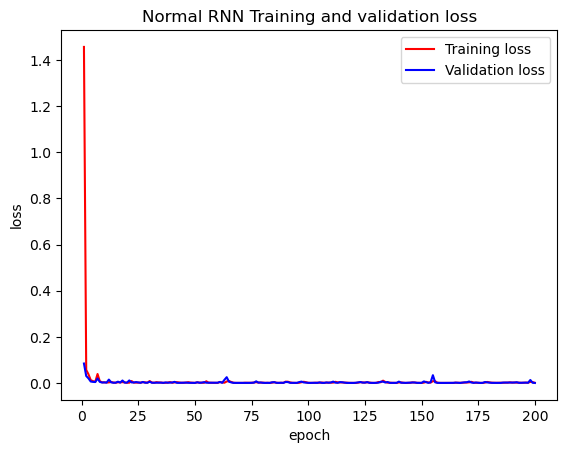

In [16]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Normal RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

C:\Users\zihaow19\AppData\Local\Temp\ipykernel_12760\2940788247.py:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


116/116 [==============================] - 9s 52ms/step
(3706, 10, 2)


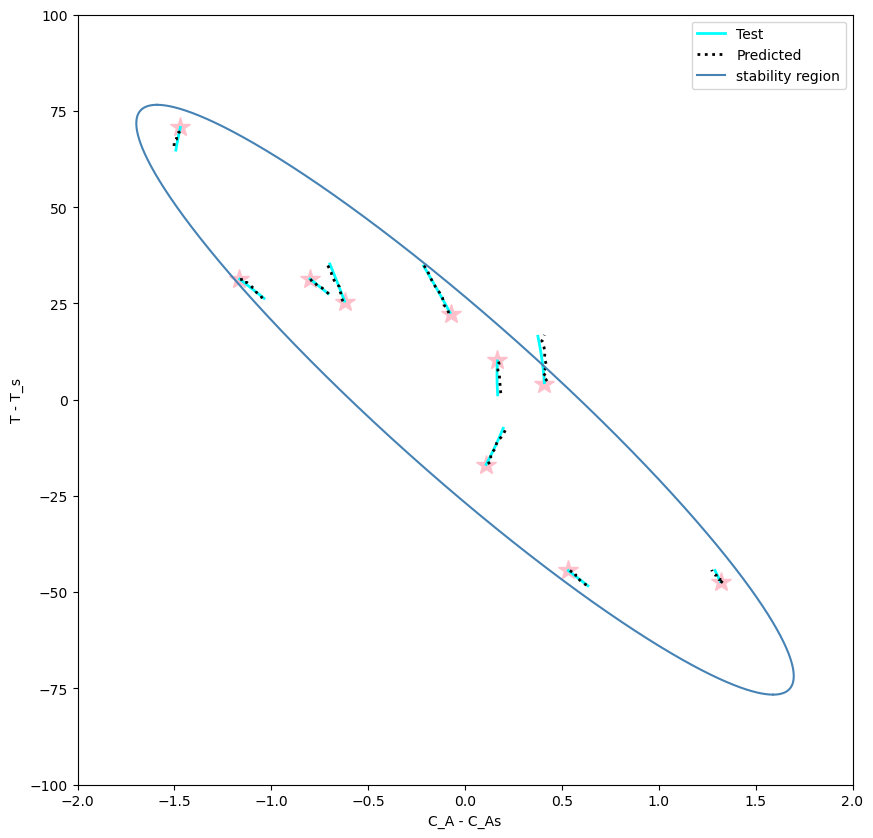

In [17]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass

plt.figure(figsize=(10,10))

# # plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,num_step,2)

X_plot = X_test.reshape(-1,num_dims)
X_plot = scaler_X.inverse_transform(X_plot)
X_plot = X_plot.reshape(-1,num_step,num_dims)

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':')

# plot stability region
plt.plot(x_lower, y_plot, color='steelblue', label='stability region')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
plt.savefig('rnn_noise_0.pdf')
plt.show()